<a href="https://colab.research.google.com/github/FG2511/ARE/blob/master/model1_Federica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''
@File name: model1.ipynb
@Created on 2018-12-20
@Authors: Federica Gerina, Francesca Moi, Silvia Maria Massa
@Description: Given a time-series dataset that contains minute-by-minute data 
about different kind of gases, collected by the uHoo air quality sensor, train
a NN that classifies if a minute belongs to the class "Pasto" (1) otherwise to
the class "Other" (0).
'''

!pip install liac-arff

import arff
import csv

import numpy as np
from numpy import savetxt

import pandas as pd
from pandas import DataFrame
from pandas import read_csv
from pandas import concat

from keras import optimizers
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.pyplot import legend


# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

  Running setup.py bdist_wheel for liac-arff ... - done
  Stored in directory: /root/.cache/pip/wheels/81/f0/15/97687f0a23a6859a7ced7e09271d321930c6641c2675d04745
Successfully built liac-arff


Using TensorFlow backend.


In [0]:
#layers : 57, 113, 226, 1 (regola: input/2, input, 2*input, 1)
#layers : 113, 229, 153, 1 (regola: a= input, b= a*2/3+c, c= b*2/3+1)

def generate_model_leaky(shape):
  
  model = Sequential()
  model.add(BatchNormalization())
  
  model.add(Dense(57, input_dim=shape, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(113, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(226, kernel_initializer='random_uniform',  use_bias = False))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha = 0.2))
  model.add(Dropout(0.5))
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [0]:
#layers : 57, 113, 226, 1 (regola: input/2, input, 2*input, 1)
#layers : 113, 229, 153, 1 (regola: a= input, b= a*2/3+c, c= b*2/3+1)

def generate_model(shape):
  
  model = Sequential()
 
  '''model.add(Dense(113, input_dim=shape, kernel_initializer='random_uniform',  bias_initializer='zeros', activation='relu'))'''
  model.add(Dense(113, input_dim=shape, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  '''model.add(Dense(229, kernel_initializer='random_uniform',  bias_initializer='zeros', activation='relu'))'''
  model.add(Dense(229, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  '''model.add(Dense(153, kernel_initializer='random_uniform',  bias_initializer='zeros', activation='relu'))'''
  model.add(Dense(153, kernel_initializer='random_uniform', use_bias = False))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0,5))
  
  model.add(Dense(1, activation='sigmoid'))
  #print(model.summary())

  return model

In [0]:
#LOAD DATA
print("Loading data...")

dataset = '/root/data/6_uHoo_featureDataset.arff'

with open (dataset, encoding='utf-8') as f:
  dataDictionary = arff.load(f)

data = np.array(dataDictionary['data'])
print("DATASET LOADED")

#CONVERTING VALUES
print("Converting values...")
for i in data:
  if(i[-1] == 'Other'): i[-1] = 0
  elif(i[-1] == 'Pasto') : i[-1] = 1

dataset = data.astype('float32')
print("CONVERSION DONE")

Loading data...
DATASET LOADED
Converting values...
CONVERSION DONE


In [0]:
'''
#NORMALIZATION
print("Normalizing values...")
mean = dataset[:].mean(axis=0)
dataset -= mean
std = dataset[:].std(axis=0)
dataset /= std
print("NORMALIZATION DONE")
'''

'\n#NORMALIZATION\nprint("Normalizing values...")\nmean = dataset[:].mean(axis=0)\ndataset -= mean\nstd = dataset[:].std(axis=0)\ndataset /= std\nprint("NORMALIZATION DONE")\n'

In [0]:
#SPLIT INTO INPUT (X) AND OUTPUT (Y) VARIABLES
s = dataset.shape[-1]
#print(s)
X = dataset[:,0:s-1]
Y = dataset[:,s-1]

#SPLIT INTO TRAINING, VALIDATION AND TEST SETS
train_rate = 80
val_rate = 10
train = round(int((dataset.shape[0]*train_rate)/100))
val = round(int((dataset.shape[0]*(train_rate+val_rate))/100))

train_data = X[:train]
train_label = Y[:train]

val_data = X[train+1:val]
val_label = Y[train+1:val]

test_data = X[val+1:]
test_label = Y[val+1:]


In [0]:
#COMPUTE CLASS WEIGHT
labels = np.unique(train_label)
classWeight = compute_class_weight('balanced', labels, train_label)
classWeight = dict(zip(labels,classWeight))

#GENERATE MODEL
model = generate_model_leaky(train_data.shape[-1])
#model = generate_model(train_data.shape[-1])

#OPTIMIZERS
adm = optimizers.Adam(lr=0.0001)

#COMPILE MODEL
model.compile(loss='binary_crossentropy', optimizer = adm , metrics=['accuracy'])

#EARLY STOPPING
es = EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')

#FIT MODEL
history = model.fit(train_data, train_label, epochs=30, validation_data = (val_data, val_label), batch_size = 128, shuffle = True, class_weight = classWeight, verbose=1, callbacks = [es])

#EVALUATE MODEL
scores_test = model.evaluate(test_data, test_label, batch_size=128, verbose = 1)
print("Test loss: %.2f%%" % (scores_test[0] * 100))
print("Test accuracy: %.2f%%" % (scores_test[1] * 100))

#CALCULATE PREDICTIONS AND SAVE IN A CSV FILE
pred = model.predict_classes(test_data, batch_size=128, verbose=0)

Train on 183944 samples, validate on 22992 samples
Epoch 1/30
183944/183944 [==============================] - 13s 73us/step - loss: 0.6969 - acc: 0.6347 - val_loss: 0.5631 - val_acc: 0.7568
Epoch 2/30
183944/183944 [==============================] - 12s 65us/step - loss: 0.6098 - acc: 0.7100 - val_loss: 0.5381 - val_acc: 0.7525
Epoch 3/30
183944/183944 [==============================] - 12s 65us/step - loss: 0.5670 - acc: 0.7327 - val_loss: 0.4590 - val_acc: 0.7985
Epoch 4/30
183944/183944 [==============================] - 12s 64us/step - loss: 0.5419 - acc: 0.7505 - val_loss: 0.4393 - val_acc: 0.7986
Epoch 5/30
183944/183944 [==============================] - 12s 64us/step - loss: 0.5187 - acc: 0.7507 - val_loss: 0.4336 - val_acc: 0.8034
Epoch 6/30
183944/183944 [==============================] - 12s 65us/step - loss: 0.5038 - acc: 0.7635 - val_loss: 0.4535 - val_acc: 0.7933
Epoch 7/30
22992/22992 [==============================] - 0s 20us/step
Test loss: 51.72%
Test accuracy: 75.94

In [0]:
#CONFUSION MATRIX
y_true = test_label
y_pred = pred
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print("TN", tn)
print("FP", fp)
print("FN", fn)
print("TP", tp)
other = 100*tn/(tn+fp)
pasto = 100*tp/(fn+tp)
print("Other corretti: %.2f %%" % other)
print("Pasto corretti: %.2f %%" % pasto)

TN 17084
FP 5100
FN 433
TP 375
Other corretti: 77.01 %
Pasto corretti: 46.41 %


In [0]:
#model.save('my_model1.h5')
#model = load_model('my_model.h5')

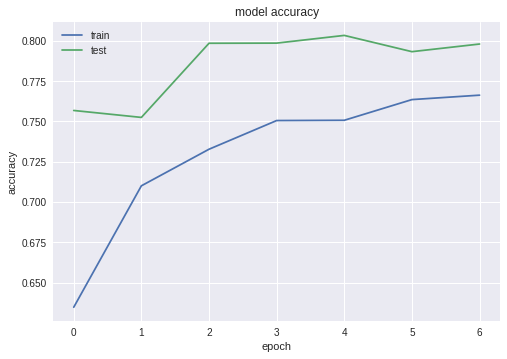

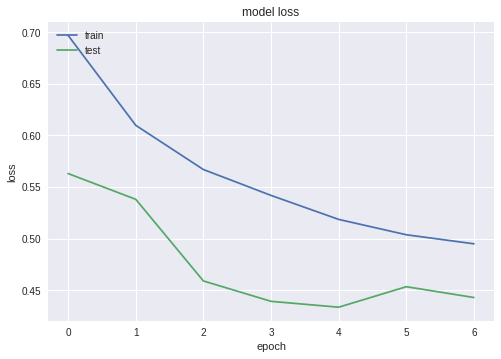

In [0]:
#PLOT RESULTS

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [0]:
#LOAD SENSORE DATA
datasetSensor = '/root/data/6_uHoo_featureDataset_Reduced.arff'

with open (datasetSensor, encoding='utf-8') as fs:
  dataSensor = arff.load(fs)

dataS = np.array(dataSensor['data'])

#CONVERTING VALUES
for i in dataS:
  if(i[-1] == 'Other'): i[-1] = 0
  else : i[-1] = 1

#TEST DATA SENSOR 
dataT = dataS[val+1:]

new_rows = []

for i,j,z in zip(dataT, test_label, pred):
  new_dict = {}
  new_dict['Temperature'] = i[0]
  new_dict['CO2'] =  i[1]
  new_dict['Actual'] = j
  new_dict['Predicted'] = z

  new_rows.append(new_dict)

keys = new_rows[0].keys()


with open("/root/data/out.csv", "w", newline='') as o:
  w = csv.DictWriter(o, keys)
  w.writeheader()
  w.writerows(new_rows)
